In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [17]:
from dataset import VOCDataset
from make_datapath_list import make_datapath_list
from data_transform import DataTransform

# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath
)

print(train_img_list[0])
print(train_anno_list[0])

# 動作確認
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.2043,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.2043,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.2043,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3256,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3256,  1.3431],
         [-0.7402, -0.4951, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


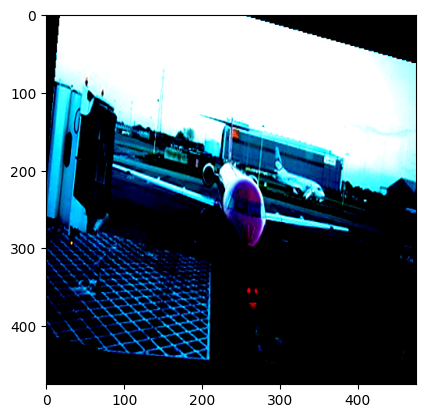

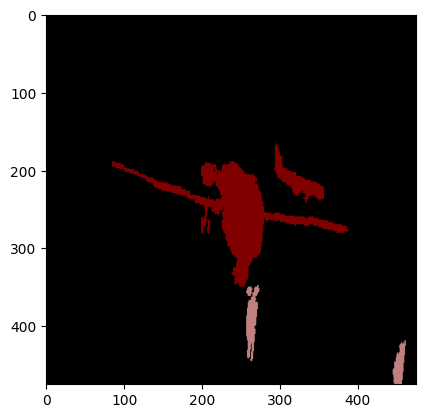

In [18]:
# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


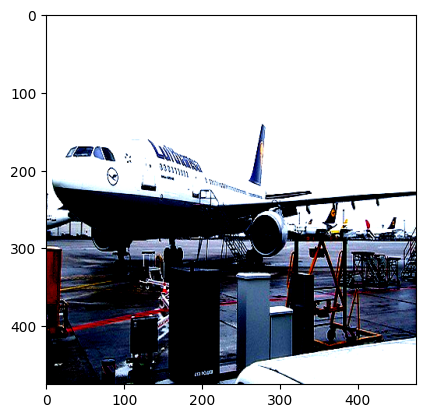

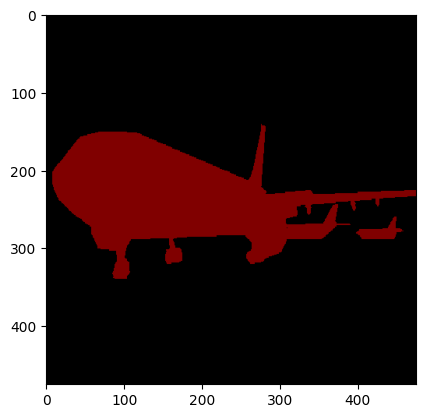

In [19]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()